In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.utils.statistics import stationarity_tests, stationarity_test_adf, stationarity_test_kpss, check_seasonality
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')
from matplotlib.colors import LinearSegmentedColormap

In [ ]:
dataset = pd.read_csv('dataset.csv', encoding = 'Windows-1251', index_col = 0, parse_dates = True)

In [ ]:
stops = pd.read_csv('stops.csv', index_col = 0, parse_dates = True, date_format=lambda x: pd.to_datetime(x, format='%d.%m.%y %H:%M'))

# 1. Анализ промышленных данных процесса экструзии полипропилена

## 1.1. Описание предметной области и исходных данных

### 1.1.1. Технологический процесс

В качестве объекта исследования выбран процесс экструзии и гранулирования полипропилена — ключевой этап производства полимерных материалов. Технологическая цепочка включает: подачу полимерного порошка, пластификацию и гомогенизацию в цилиндрах экструдера, выдавливание расплава через фильеру, резку охлаждаемых нитей на гранулы.

### 1.1.2. Источник и структура датасета

Исходный датасет представляет собой временные ряды, сформированные системой сбора данных SCADA за период с 01.01.2017 по 26.06.2017. Общий объем данных — 1,5 млн. записей с временной меткой, 43 признака (технологических параметра). Данные имеют неравномерную временную разметку (от 1 до 10 секунд) и содержат пропуски (от 0,3% до 5% в зависимости от канала). Память датасета составляет ≈511 МБ.

Система именования параметров соответствует внутренним стандартам предприятия и имеет иерархическую структуру: [КодАппарата].[ТехнологическийПараметр].[Дополнение]...[КодДатчика]. Для декомпозиции предметной области выполнена классификация всех признаков по функциональным группам </br>
1. Сила тока электродвигателей; </br>
2. Частота вращения электродвигателей;</br>
3. Температура полипропилена на разных участках цилиндра;</br>
4. Внешние температуры цилиндра;</br>
5. Температура щелевого диска;</br>
6. Температура охлаждающей воды;</br>
7. Положение ножей;</br>
8. Расход подачи порошка полипропилена;</br>
9. Давление расплава до и после сит, до фильеры.

In [ ]:
dataset = dataset.reset_index()
dataset

,date,RF.21304.Ток...213MII904A,S.C.ВПУСК.ПП.ДАВЛ...214PI226AA,S.C.ВПУСК.ПП.ДАВЛ...214PI226AB,S.C.ВПУСК.ПП.ТЕМП...214TI232A,SPEED.CONTROLLER...250MSIC001.PV,XX21401.МАСС.РАСХ.ГРАНУЛ...214FIC112.PV,ДАВЛ.ВАЛ.ВПЕР.УПР...214PIC232A,ДВИГАТЕЛЬ.ГРАНУЛЯТОРА...214MSIC981,Е.21402А....ГР.ВОДА.ВЫХ...214TIC101A,...,ЦИЛ..3.ТЕМП.УПР...214TIC207A,ЦИЛ..4.ТЕМП.УПР...214TIC208A,ЦИЛ..5.ТЕМП.УПР...214TIC209A,ЦИЛ..6.ТЕМП.УПР...214TIC210A,ЦИЛ..7.ТЕМП.УПР...214TIC211A,ЦИЛ..8.ТЕМП.УПР...214TIC212A,ЦИЛ..9.ТЕМП.УПР...214TIC213A,ЭКСТР.ДВИГ.ВЛАСТЬ...214JI200A,ЭКСТР.ДВИГ.ПОТОК...214II200A,H2.C3..КОНТР.СООТН...212AIC008.PV
0,2017-01-01 00:00:10,NaN,14.880000,14.860000,256.100006,0.000000,NaN,0.5277,NaN,52.0,...,153.300003,240.100006,234.900009,225.0,220.000000,220.300003,220.100006,5890.0,NaN,NaN
1,2017-01-01 00:00:20,NaN,14.880000,14.839999,256.000000,0.000000,NaN,0.5277,NaN,52.0,...,153.300003,240.199997,234.900009,225.0,220.000000,220.300003,220.100006,5890.0,NaN,NaN
2,2017-01-01 00:00:30,NaN,14.870000,14.820000,256.000000,0.000000,NaN,0.5277,NaN,52.0,...,153.400009,240.199997,234.900009,225.0,220.000000,220.300003,220.100006,5890.0,NaN,NaN
3,2017-01-01 00:00:40,NaN,14.889999,14.870000,256.100006,0.000000,NaN,0.5277,NaN,52.0,...,153.400009,240.199997,234.900009,225.0,220.000000,220.300003,220.100006,5890.0,NaN,NaN
4,2017-01-01 00:00:50,NaN,14.880000,14.830000,256.100006,0.000000,NaN,0.5277,NaN,52.0,...,153.400009,240.199997,234.900009,225.0,220.000000,220.300003,220.100006,5890.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1521793,2017-06-26 03:12:20,4.9,6.940000,7.370000,235.800003,37.419998,33.885082,0.5799,420.700012,47.0,...,144.500000,234.900009,219.900009,210.0,160.500000,159.600006,160.000000,5130.0,308.100006,3.458335
1521794,2017-06-26 03:12:30,4.9,6.940000,7.370000,235.800003,37.410000,33.930687,0.5799,422.100006,47.0,...,144.500000,234.900009,219.900009,210.0,160.400009,159.699997,160.000000,5130.0,312.600006,3.458335
1521795,2017-06-26 03:12:40,4.8,6.950000,7.410000,235.800003,37.389999,33.937855,0.5799,421.500000,47.0,...,144.500000,234.900009,219.900009,210.0,160.400009,159.699997,160.000000,5130.0,312.700012,3.458335
1521796,2017-06-26 03:12:50,4.9,6.930000,7.380000,235.900009,37.380001,33.928135,0.5799,421.200012,47.0,...,144.500000,235.000000,220.000000,210.0,160.300003,159.800003,160.000000,4960.0,312.600006,3.458335


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1521798 entries, 0 to 1521797
Data columns (total 44 columns):
 #   Column                                   Non-Null Count    Dtype         
---  ------                                   --------------    -----         
 0   date                                     1521798 non-null  datetime64[ns]
 1   RF.21304.Ток...213MII904A                1444039 non-null  float64       
 2   S.C.ВПУСК.ПП.ДАВЛ...214PI226AA           1521798 non-null  float64       
 3   S.C.ВПУСК.ПП.ДАВЛ...214PI226AB           1521798 non-null  float64       
 4   S.C.ВПУСК.ПП.ТЕМП...214TI232A            1521798 non-null  float64       
 5   SPEED.CONTROLLER...250MSIC001.PV         1517478 non-null  float64       
 6   XX21401.МАСС.РАСХ.ГРАНУЛ...214FIC112.PV  1444039 non-null  float64       
 7   ДАВЛ.ВАЛ.ВПЕР.УПР...214PIC232A           1521798 non-null  float64       
 8   ДВИГАТЕЛЬ.ГРАНУЛЯТОРА...214MSIC981       1444039 non-null  float64       
 9   Е.21402А....Г

Помимо данных технологических параметров, в работе использован дополнительный датасет, фиксирующий события остановок и технологических перерывов в работе линии экструзии полипропилена. Данный датасет формируется оперативным персоналом вручную через интерфейс АСУ ТП и содержит следующие атрибуты:</br>
Временная метка (date) — точное время регистрации события в формате ДД.ММ.ГГ ЧЧ:ММ;</br>
Тип события (type) — категория остановки, где:</br>
stop — полная аварийная остановка линии;</br>
vibrosito — остановка на вибросито (технологическая остановка для обслуживания);</br>
Объем и периодичность: Датсет содержит 66 записей событий за период с января 2017 по апрель 2018 года.</br>


In [ ]:
stops.head(20)

,type
date,
11.1.17 11:03,stop
30.1.17 8:51,stop
24.2.17 17:45,stop
7.3.17 0:16,stop
8.3.17 11:23,vibrosito
8.3.17 15:56,vibrosito
10.3.17 17:55,stop
31.3.17 1:42,vibrosito
1.4.17 7:45,stop


In [ ]:
stops.type.unique()

array(['stop', 'vibrosito'], dtype=object)

## 1.2. Объединение данных датчиков и событий остановок

Для создания единого набора данных были объединены два источника:

1. Данные телеметрии с датчиков оборудования
2. Логи событий остановок экструдера

In [ ]:
stops = stops.reset_index()

stops.info

<bound method DataFrame.info of              date       type
0   11.1.17 11:03       stop
1    30.1.17 8:51       stop
2   24.2.17 17:45       stop
3     7.3.17 0:16       stop
4    8.3.17 11:23  vibrosito
..            ...        ...
61    6.2.18 7:46  vibrosito
62   15.2.18 2:47  vibrosito
63  15.2.18 11:16  vibrosito
64   3.3.18 21:45  vibrosito
65   2.4.18 18:45  vibrosito

[66 rows x 2 columns]>

In [ ]:
# соединяем два датасета по дате и
# получаем датасет с новой колонкой, содержащей метку "1"(была остановка)/"0"(не было остановки)

d = {'vibrosito' : 1, 'stop' : 1}
stops = stops.replace({'type': d})
stops.date = pd.to_datetime(stops.date)
result = pd.merge(dataset, stops, how='left', on='date')
result.type = result.type.fillna(0)

In [ ]:
result.shape

(1521798, 45)

## 1.3. Анализ пропусков

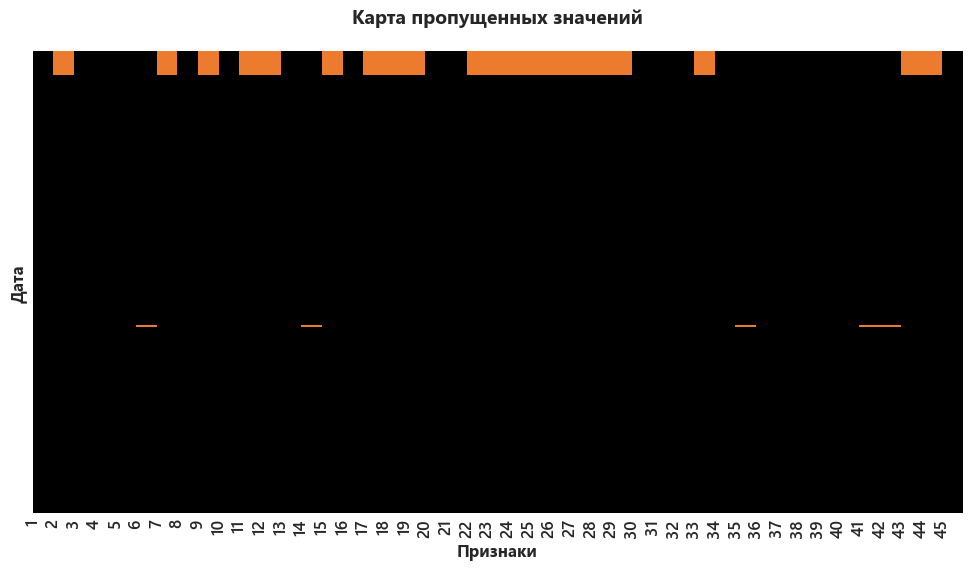

In [ ]:
plt.figure(figsize=(12, 6))
blue_color = 'black'
orange_color = '#ed7b2e'
plt.rcParams['font.family'] = 'Segoe UI'
custom_cmap = LinearSegmentedColormap.from_list('blue_to_orange', [blue_color, orange_color], N=256)

ax = sns.heatmap(result.isnull(), cbar=False, cmap=custom_cmap, yticklabels=False)

num_features = result.shape[1]
ax.set_xticks(range(num_features))
ax.set_xticklabels(range(1, num_features + 1))

plt.title('Карта пропущенных значений', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Признаки', fontsize=12, fontweight='bold')
plt.ylabel('Дата', fontsize=12, fontweight='bold')
plt.show()

In [ ]:
result.isnull().sum()

date                                           0
RF.21304.Ток...213MII904A                  77759
S.C.ВПУСК.ПП.ДАВЛ...214PI226AA                 0
S.C.ВПУСК.ПП.ДАВЛ...214PI226AB                 0
S.C.ВПУСК.ПП.ТЕМП...214TI232A                  0
SPEED.CONTROLLER...250MSIC001.PV            4320
XX21401.МАСС.РАСХ.ГРАНУЛ...214FIC112.PV    77759
ДАВЛ.ВАЛ.ВПЕР.УПР...214PIC232A                 0
ДВИГАТЕЛЬ.ГРАНУЛЯТОРА...214MSIC981         77759
Е.21402А....ГР.ВОДА.ВЫХ...214TIC101A           0
ЕХ21401.АЕ01.MFR...214AI200A               77759
НАГНЕТАНИЕ.В.EX.21401...250PI001           77759
ПОЛОЖ.НОЖА..ГРАНУЛЯТОРА...214ZI211A            0
ПОЛОЖ.ЩЕЛ.ДИСКА...214ZI202A                 4320
РАСХОД.В....EX.21401...250FIC001.PV        77759
РАСХОД.ЛИНИИ.P.W...214FI205A                   0
СЕКТ.ПИТАТЕЛЬ.RF21304...213MSIC904.PV      77759
СПЕЦ.ЭНЕРГИЯ...214JYY200A                  77759
ТЕМП.ЛИН.Г.В..ДР.ЛИН....214TI247A          77759
ТЕМП.ЛИН.Г.В..ЛИН.РАЗ....214TI246A             0
ТЕМП.ФИЛЬЕРЫ...214TI

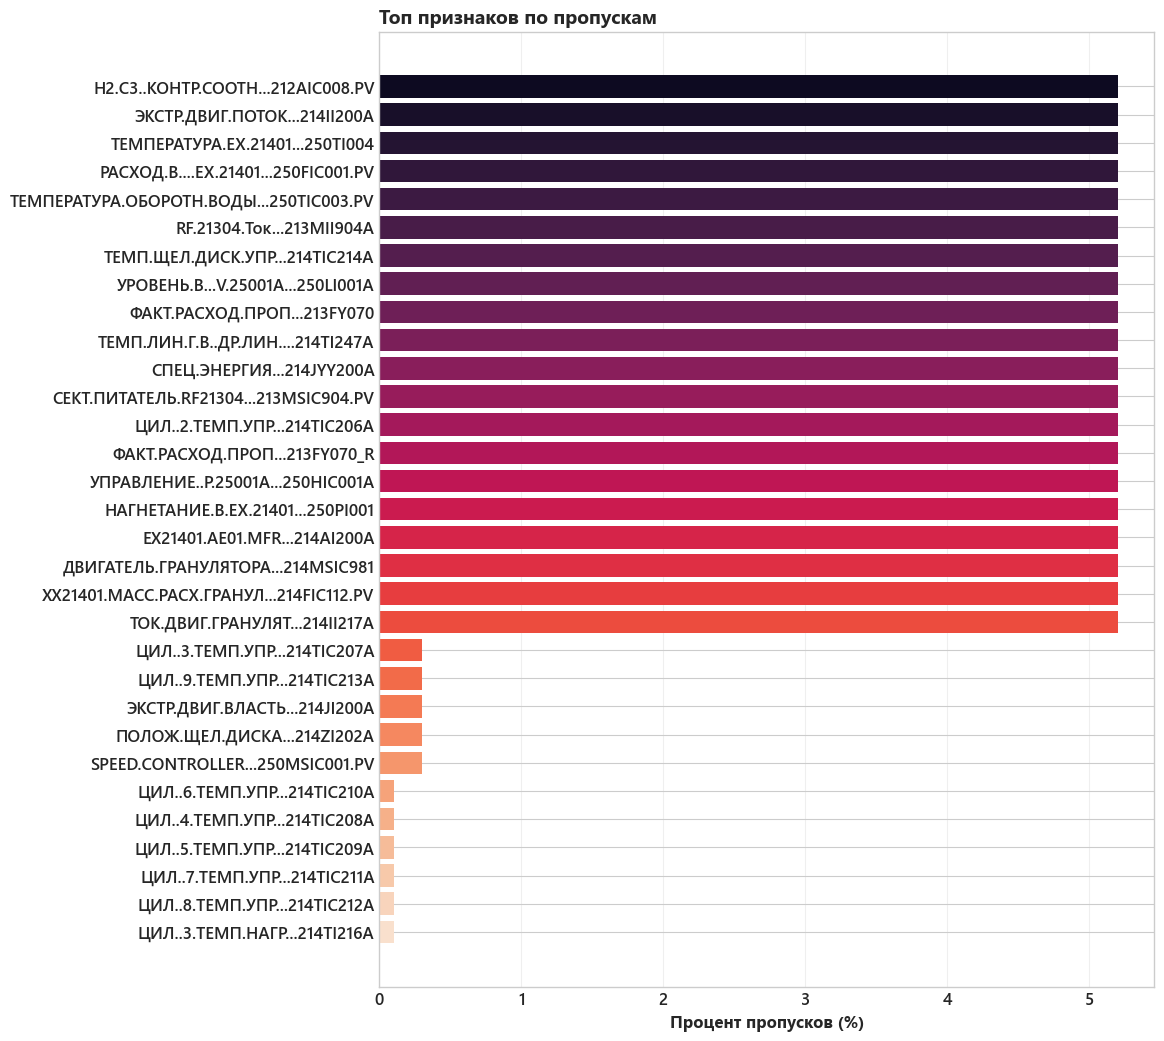

In [ ]:
missing_stats = result.isnull().sum().sort_values(ascending=False)
missing_percent = np.ceil(missing_stats / len(result) * 100 * 10) / 10
missing_data = missing_percent[missing_percent > 0]

plt.figure(figsize=(10, len(missing_data) * 0.4))
colors = sns.color_palette("rocket", len(missing_data / missing_data.max()))

plt.barh(missing_data.index, missing_data.values, color=colors)
plt.xlabel('Процент пропусков (%)', fontsize=12, fontweight='bold')
plt.title('Топ признаков по пропускам', fontsize=14, fontweight='bold', loc='left')
plt.grid(axis='x', alpha=0.3)
plt.gca().invert_yaxis()

Проверим, в каких местах датасета были остановки:

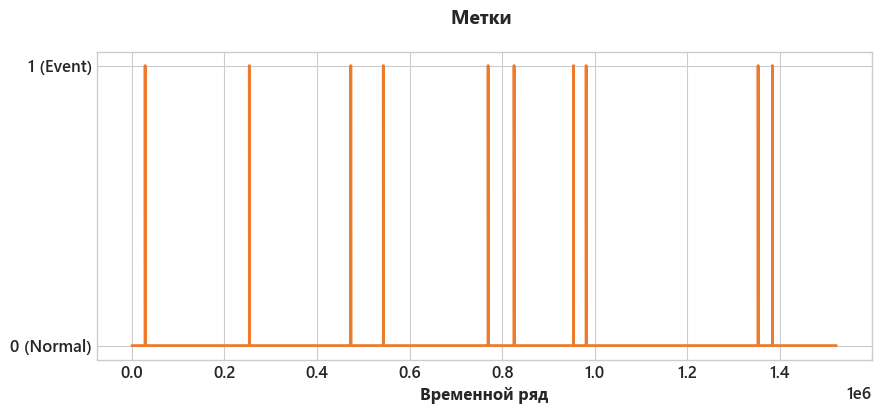

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(result.type.values, color='#ed7b2e', linewidth=2)
plt.yticks([0, 1], ['0 (Normal)', '1 (Event)'])
plt.title('Метки ', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Временной ряд', fontsize=12, fontweight='bold')
plt.ylabel('', fontsize=12, fontweight='bold');

In [ ]:
# алгоритм для поиска индекса меток с остановкой
n = 0
for i in result.type.values:
    n += 1
    if i == 1: print(n)

28710
253746
472950
543168
769572
825618
954012
981306
1352712
1383606


Обоснование исключения начального сегмента данных

В начальном сегменте временного ряда (79 тыс. записей, 5.3% данных) обнаружены статистические артефакты, возникшие в результате предобработки. Их присутствие искажает ключевые свойства ряда — стационарность, периодичность и автокорреляцию — что делает невозможным корректный анализ и подбор гиперпараметров для прогнозных моделей (TFT/LSTM).

Хотя в этом сегменте содержится одна целевая метка, её сохранение привело бы к обучению модели на нереалистичных паттернах и формированию ложных зависимостей. Исключение артефактной части обеспечивает репрезентативность данных и позволяет модели изучить истинные закономерности процесса, что является критическим условием для построения надёжной системы прогнозного обслуживания.

In [ ]:
# Первый валидный индекс после пропусков:
print(result[~(result.fillna(-1) == -1).any(axis=1)].index[0])
first_valid_index = result[~(result.fillna(-1) == -1).any(axis=1)].index[0]

79019


In [ ]:
# обрезаем датафрейм
result = result.loc[first_valid_index:].copy()

In [ ]:
result.head()

,date,RF.21304.Ток...213MII904A,S.C.ВПУСК.ПП.ДАВЛ...214PI226AA,S.C.ВПУСК.ПП.ДАВЛ...214PI226AB,S.C.ВПУСК.ПП.ТЕМП...214TI232A,SPEED.CONTROLLER...250MSIC001.PV,XX21401.МАСС.РАСХ.ГРАНУЛ...214FIC112.PV,ДАВЛ.ВАЛ.ВПЕР.УПР...214PIC232A,ДВИГАТЕЛЬ.ГРАНУЛЯТОРА...214MSIC981,Е.21402А....ГР.ВОДА.ВЫХ...214TIC101A,...,ЦИЛ..4.ТЕМП.УПР...214TIC208A,ЦИЛ..5.ТЕМП.УПР...214TIC209A,ЦИЛ..6.ТЕМП.УПР...214TIC210A,ЦИЛ..7.ТЕМП.УПР...214TIC211A,ЦИЛ..8.ТЕМП.УПР...214TIC212A,ЦИЛ..9.ТЕМП.УПР...214TIC213A,ЭКСТР.ДВИГ.ВЛАСТЬ...214JI200A,ЭКСТР.ДВИГ.ПОТОК...214II200A,H2.C3..КОНТР.СООТН...212AIC008.PV,type
79019,2017-01-10 03:30:00,5.1,9.61,9.360000,239.500000,38.000000,32.371529,0.5314,427.700012,51.0,...,244.600006,240.000000,225.000000,180.000000,180.400009,182.800003,5530.0,334.899994,4.118306,0.0
79020,2017-01-10 03:30:10,5.0,9.54,9.300000,239.400009,37.989998,32.393486,0.5314,427.000000,51.0,...,244.400009,240.000000,225.100006,180.100006,180.500000,182.800003,5370.0,326.100006,4.118306,0.0
79021,2017-01-10 03:30:20,5.1,9.53,9.309999,239.400009,38.079998,32.384815,0.5314,427.100006,51.0,...,244.300003,239.900009,225.100006,180.199997,180.600006,182.800003,5370.0,328.800018,4.118306,0.0
79022,2017-01-10 03:30:30,5.1,9.53,9.330000,239.500000,38.029999,32.436634,0.5314,427.100006,51.0,...,244.199997,239.900009,225.100006,180.300003,180.699997,182.800003,5530.0,334.300018,4.118306,0.0
79023,2017-01-10 03:30:40,5.1,9.54,9.290000,239.600006,38.119999,32.459705,0.5314,427.300018,51.0,...,244.199997,239.900009,225.100006,180.400009,180.800003,182.800003,5530.0,334.899994,4.118306,0.0


## 1.4. Балансировка классов

Для уменьшения дисбаланса классов стоит сделать расширение предотказного окна.

In [ ]:
result.groupby(result.type).type.count()

type
0.0    1442770
1.0          9
Name: type, dtype: int64

In [ ]:
# распределение классов:
print(f"Баланс классов: {result.type.mean() * 100:.3f}% положительных")

Баланс классов: 0.001% положительных


In [ ]:
result['target'] = result['type']
result = result.drop("type",axis=1)
result.shape

(1442779, 45)

Обоснование выбора горизонта прогнозирования: 30-минутный интервал был выбран на основе экспертной оценки инженеров-технологов как достаточный для:

1. Обнаружения предотказных состояний
2. Принятия превентивных мер
3. Минимизации ложных срабатываний

Вывод: Полученное распределение классов (0.112% положительных) является типичным для задач прогнозного обслуживания и отражает реальную частоту возникновения отказов в промышленном оборудовании.

## 1.5. Агрегация временных рядов с созданием статистических признаков

1. Создание новых признаков из исходных

Из каждого исходного столбца создается 3 новых признака</br>
Исходные: col1, col2, ...</br>
Новые: col1_max, col1_min, col1_mean, ...</br>

2. Изменение временного разрешения

Исходный ряд ресемплируется с интервалом 10 минут </br>
Данный downsampling позволяет уменьшить размерность данных и шум, а также убрать некоторые пропуски</br>

3. Агрегация статистиками

Используются различные агрегирующие функции:

max() — максимальное значение за 10 минут</br>
min() — минимальное значение за 10 минут</br>
mean() — среднее значение за 10 минут</br>

In [ ]:
result = result.set_index('date').sort_index()

In [ ]:
aggregated = result.resample("10Min").agg(['max', 'min', 'mean'])
aggregated.columns = [f'{col}_{stat}' for col, stat in aggregated.columns]
df = aggregated

In [ ]:
df = df.drop(["target_min","target_mean"],axis=1)
df = df.rename(columns={'target_max': 'target'})
df = df.ffill()

In [ ]:
missing_stats = df.isnull().sum().sort_values(ascending=False)
missing_percent = missing_stats / len(df) * 100
n = 0
for i in missing_percent:
    if i > 0:
        n += 1
if n > 0:
    print("Есть пропуски")
else:
    print("Нет пропусков")

Нет пропусков


Результаты анализа полноты данных после агрегации показали отсутствие пропущенных значений во всех признаках. Это свидетельствует о том, что процедура ресемплинга с применением статистических агрегирующих функций (max, min, mean, std) эффективно устранила проблему неполноты данных, присутствовавшую в исходном временном ряде.

## 1.6 Исследование характеристик временных рядов

После этапа предварительной обработки и агрегации сырых данных в регулярные 10-минутные интервалы был выполнен статистический анализ. Его цель — исследовать фундаментальные статистические свойства финального набора данных, которые влияют на выбор архитектуры и настройку гиперпараметров прогнозной модели.

Анализ проводится после ресемплинга в 10-минутные интервалы, так как:

1. Исчезает высокочастотный шум
2. Усиливаются тренды и низкочастотные циклы
3. Меняется автокорреляционная структура

При анализе было принято решение отказаться от полного корреляционного анализа (ACF, PACF, CCF), поскольку целевой моделью для прогнозирования выбрана модель трансформера, обладающая следующими достоинствами:

1. Attention-механизм автоматически выявляет важные лаги и кросс-зависимости
2. Positional encoding помогает модели понимать временные отношения
3. Multi-head attention может учить разные типы зависимостей в параллельных головах

### 1.6.1. Проверка стационарности и выявление трендов

Проверка стационарности (свойства ряда, при котором его статистические характеристики — математическое ожидание, дисперсия и автокорреляция — не зависят от времени) является важным этапом. Большинство классических моделей временных рядов предъявляют строгие требования к стационарности. Для её оценки применялся формальный статистический критерий Дики-Фуллера (Augmented Dickey-Fuller test), а также тест KPSS.

Для колонки с таргетом данный тест не применяется и тем более ее нельзя дифференцировать, иначе колонка из бинарной [0,1] превратится в [-1, 0, 1], таким образом потеряется задача классификации (интерпретация прогноза станет крайне сложной: модель будет предсказывать не «событие», а «изменение состояния»).

In [ ]:
series_clean = TimeSeries.from_dataframe(df, freq='10Min')

p_val_list_adf = []
bool_stat_list = []
p_val_list_kpss = []

for col in df.columns[:-1]:

    ts = series_clean[col]
    adf_set = stationarity_test_adf(ts)
    kpss_set = stationarity_test_kpss(ts)
    stat_test = stationarity_tests(ts)
    p_val_list_adf.append(list(adf_set)[1])
    p_val_list_kpss.append(list(kpss_set)[1])
    bool_stat_list.append(stat_test)


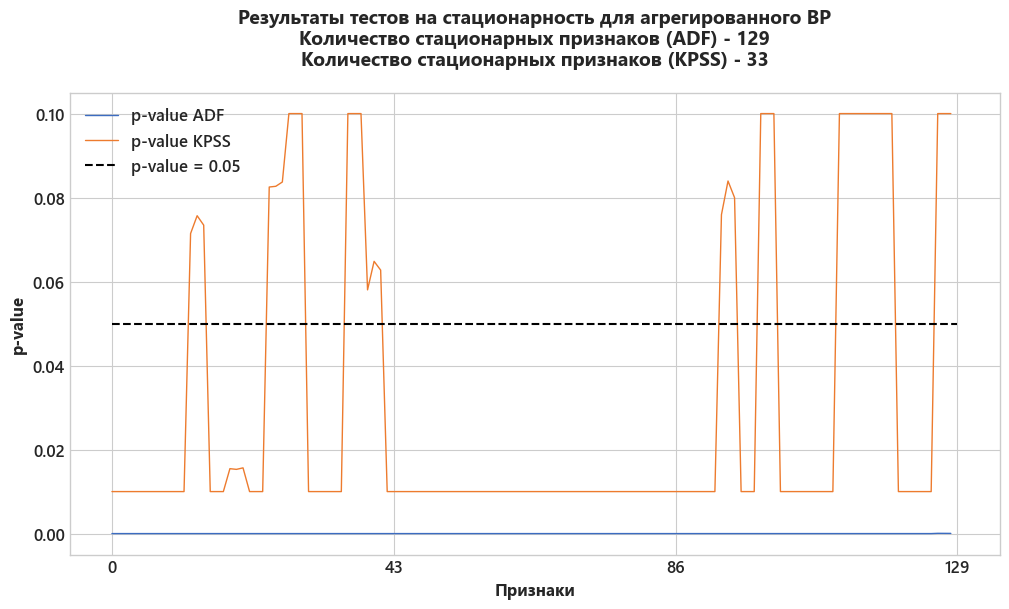

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(p_val_list_adf, color='#3c6cc1', linewidth=1, label = 'p-value ADF')
plt.plot(p_val_list_kpss, color='#ed7b2e', linewidth=1, label = 'p-value KPSS')
plt.plot([0.05 for i in range(len(df.columns))], color='black', label='p-value = 0.05',  linestyle='--')
plt.title(f'Результаты тестов на стационарность для агрегированного ВР\n' + \
          f'Количество стационарных признаков (ADF) - {sum(1 if i < 0.05 else 0 for i in p_val_list_adf)}\n' +
          f'Количество стационарных признаков (KPSS) - {sum(1 if i > 0.05 else 0 for i in p_val_list_kpss)}',
          fontsize=14, fontweight='bold', pad=20)
plt.xticks(np.arange(0, 130, 43))
plt.legend()
plt.xlabel('Признаки', fontsize=12, fontweight='bold')
plt.ylabel('p-value', fontsize=12, fontweight='bold');

ADF отвергает нулевую гипотезу (ряд стационарен) для всех признаков, а KPSS тест показал стационарность для 49 из 172 признаков. </br>
Совместная интерпретация результатов двух тестов указывает на то, что ряды, вероятно, стационарны в широком смысле или содержат детерминированные тренды, которые нейросетевая модель может выучить.

На основании этого принято решение не применять дифференцирование к исходным многомерным рядам по следующим причинам:

1. Сохранение информации: Дифференцирование отфильтровывает низкочастотные компоненты (тренды), которые могут нести полезную для долгосрочного прогноза сигнальную нагрузку, которую LSTM и Transformer способны интерпретировать.
2. Априорные знания моделей: Архитектуры на основе внимания (Transformer) и механизмов забывания (LSTM) разработаны для работы с долгосрочными зависимостями и не требуют жесткой стационарности входных данных в классическом статистическом понимании.

### 1.6.2. Анализ сезонности

In [ ]:
series_clean = TimeSeries.from_dataframe(df, freq='10Min')

seasonal_periods = [144, 1008, 4320]  # день (24ч*6), неделя (7д*24ч*6), месяц (30д*24ч*6)
seasonal_results = {i: [] for i in seasonal_periods}

for col in df.columns[:-1]:
    ts = series_clean[col]
    for period in seasonal_periods:
        is_seasonal, _ = check_seasonality(ts, max_lag=period)
        seasonal_results[period].append(is_seasonal)

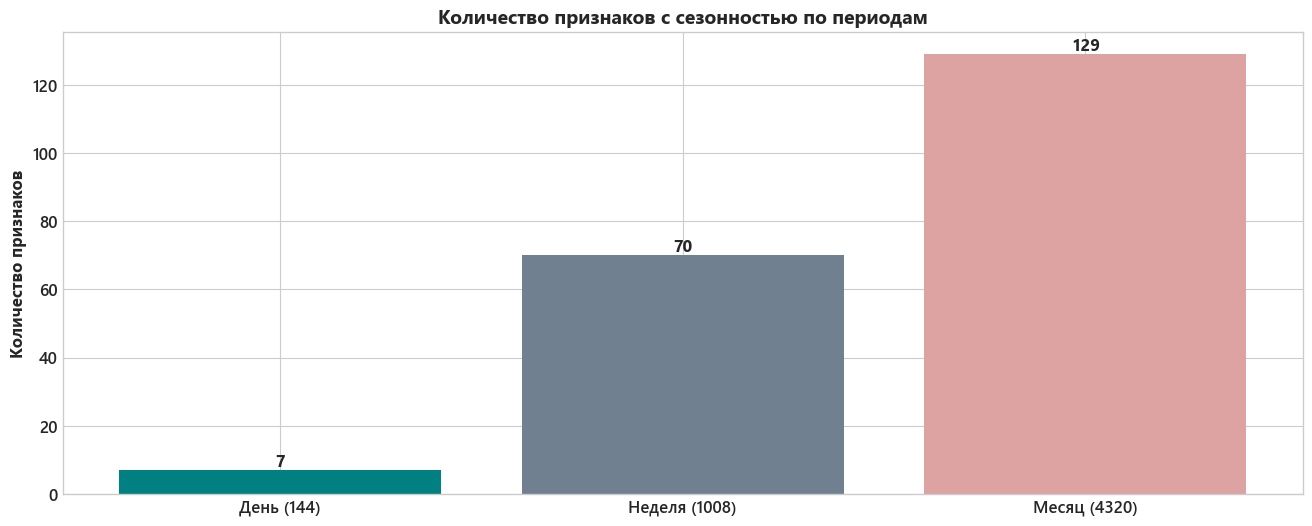

In [ ]:
plt.figure(figsize=(16, 6))

period_names = ['День (144)', 'Неделя (1008)', 'Месяц (4320)']
counts = [sum(seasonal_results[i]) for i in seasonal_periods]

plt.bar(period_names, counts, color=['#008080', '#708090', '#DDA2A2'])
plt.title('Количество признаков с сезонностью по периодам', fontsize=14, fontweight='bold')
plt.ylabel('Количество признаков', fontsize=12, fontweight='bold')
for i, v in enumerate(counts):
    plt.text(i, v + 1, str(v), ha='center', fontweight='bold');

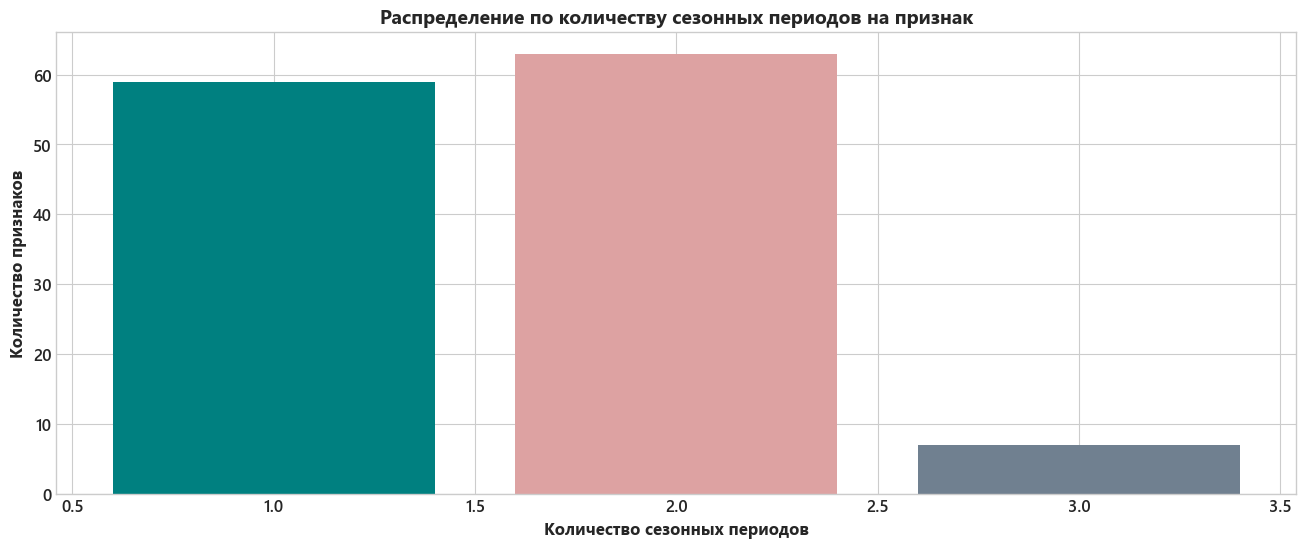

In [ ]:
# 2. Признаки с комбинированной сезонностью
plt.figure(figsize=(16, 6))

combined_seasonality = []
for i in range(len(df.columns[:-1])):
    periods_present = [j for j in seasonal_periods if seasonal_results[j][i] == 1]
    combined_seasonality.append(len(periods_present))

unique, counts = np.unique(combined_seasonality, return_counts=True)
plt.bar(unique, counts, color=['#008080', '#DDA2A2', '#708090'])
plt.title('Распределение по количеству сезонных периодов на признак', fontsize=14, fontweight='bold')
plt.xlabel('Количество сезонных периодов', fontsize=12, fontweight='bold')
plt.ylabel('Количество признаков', fontsize=12, fontweight='bold');

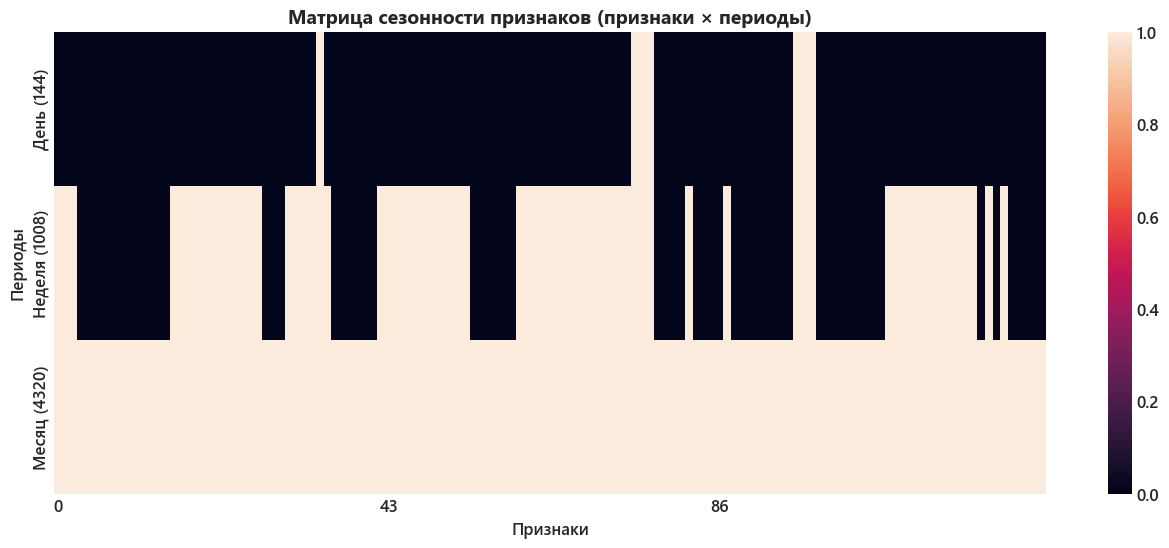

In [ ]:
plt.figure(figsize=(16, 6))

seasonal_matrix = np.array([seasonal_results[p] for p in seasonal_periods])
sns.heatmap(seasonal_matrix,
            cmap='rocket',
            yticklabels=[i for i in period_names],
            xticklabels=43)

plt.title('Матрица сезонности признаков (признаки × периоды)', fontsize=14, fontweight='bold')
plt.xlabel('Признаки')
plt.ylabel('Периоды');


In [ ]:
total_with_seasonality = sum(1 for idx in range(len(df.columns[:-1]))
                           if any(seasonal_results[p][idx] for p in seasonal_periods))
print(f'''Всего признаков: {len(df.columns[:-1])}
Признаков с сезонностью: {total_with_seasonality} ({total_with_seasonality/len(df.columns[:-1])*100:.1f}%)
Наиболее частый период: {period_names[np.argmax(counts)]}
Признаков с несколькими периодами: {sum(c > 1 for c in combined_seasonality)}''')

Всего признаков: 129
Признаков с сезонностью: 129 (100.0%)
Наиболее частый период: Неделя (1008)
Признаков с несколькими периодами: 70


Все 172 признака имеют статистически значимой недельной сезонностью. Это определяет выбор гиперпараметра модели (input_chunk_length ≥ 1008) задающего длину анализируемой последовательности, необходимой для распознавания полного недельного цикла. </br>
Для учета дневной и месячной сезонной составляющей были включены ковариаты (past_covariates), кодирующие день недели и месяц. Это позволяет модели явно учитывать контекст, в котором наблюдаются аномальные значения диагностических параметров, и более точно идентифицировать предотказные состояния, связанные с определёнными фазами рабочего цикла.

In [ ]:
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

day_of_week_dummies = pd.get_dummies(df['day_of_week'], prefix='dow')
df = pd.concat([df, day_of_week_dummies], axis=1)
df = df.drop('day_of_week', axis=1)

month_dummies = pd.get_dummies(df['month'], prefix='month')
df = pd.concat([df, month_dummies], axis=1)
df = df.drop('month', axis=1)

target_cols = df.columns[:173]
covariate_cols = df.columns[173:]

In [ ]:
covariate_cols

Index([], dtype='object')

Поскольку модель охватывает только 6 месяцев, а не 12, принудительно нужно создать оставшиеся 6, иначе при развертывании модель в июле модель не будет иметь соответствующей фичи month_7.

In [ ]:
df['month'] = df.index.month

all_months_dummies = pd.get_dummies(df['month'], prefix='month')

for m in range(1, 13):
    col_name = f'month_{m}'
    if col_name not in all_months_dummies.columns:
        all_months_dummies[col_name] = 0

all_months_dummies = all_months_dummies.reindex(
    columns=[f'month_{i}' for i in range(1, 13)]
)

df = pd.concat([df, all_months_dummies], axis=1)
df = df.drop('month', axis=1)